In [17]:
import logging


logging.basicConfig(
    level=logging.DEBUG,
    format="%(levelname)s: %(message)s",
    force=True,
)

In [14]:
from src.datasets.cifar10_dataset import MiniCIFAR10Dataset
from src.models.compression.enums import Activation, NNParamsCompMode
from src.models.eval import NNArchitectureEvaluator
from src.models.nn import ActivationParams


from src.models.builders.architecture_builder import BuilderParams
from src.models.builders.VGGNet_builder import VGGNetBuilder

builder_params = BuilderParams(
    conv_compression=NNParamsCompMode.NONE,
    conv_bitwidth=8,
    conv_activation=ActivationParams(Activation.RELU),
    fc_compression=NNParamsCompMode.BINARY,
    fc_bitwidth=8,
    fc_activation=ActivationParams(Activation.RELU),
    DatasetCls=MiniCIFAR10Dataset,
)
builder = VGGNetBuilder(builder_params)
params = builder.get_params()

evaluator = NNArchitectureEvaluator(params.train)
evaluator.evaluate_complexity(params)

170988195.0

In [15]:
params.get_model()

CNN(
  (quantize_input): Identity()
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2dWrapper(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2dWrapper(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2dWrapper(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2dWrapper(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256,

In [18]:

import pandas as pd
from src.datasets.mnist_dataset import MiniMNIST32x32Dataset
from src.experiment1 import run
from src.models.builders.LeNet5_builder import LeNet5Builder


df = run(MiniCIFAR10Dataset, VGGNetBuilder, 3, 1)
df.to_csv("tmp3.csv", index=False)
# df = pd.read_csv("tmp.csv")
# df = pd.read_csv(REPORTS_FOLDER + "/2025-06-01T08:47:50/experiment1_results.csv")
df.info()
df.head()

INFO: Running experiment on MiniCIFAR10Dataset with VGGNetBuilder architecture...
INFO: Evaluating LeNet5
INFO: builder.p.conv_compression.name='BINARY', builder.p.conv_activation.activation.name='NONE'
INFO: builder.p.fc_compression.name='BINARY', builder.p.fc_activation.activation.name='NONE'
DEBUG: Train Epoch:  1 [ 800/3200] Loss: 2.3905
DEBUG: Train Epoch:  1 [1600/3200] Loss: 2.4346
DEBUG: Train Epoch:  1 [2400/3200] Loss: 2.3317
DEBUG: Train Epoch:  1 [3200/3200] Loss: 2.2191
DEBUG: Test set: Average loss: 2.3383, Accuracy: 104/800 (13.00%)


KeyboardInterrupt: 

In [12]:
import plotly.express as px

px.scatter(
    df,
    x="best",
    y="cost",
    color="conv_activation",
    symbol="conv_compression",
    title=f"Experiment 1: {MiniMNIST32x32Dataset.__name__} with {LeNet5Builder.get_name()}",
    labels={
        "conv_bitwidth": "Convolutional Layer Bitwidth",
        "fc_bitwidth": "Fully Connected Layer Bitwidth",
        "best": "Accuracy (%)",
        "cost": "Model Complexity",
    }
).show()


In [8]:
from src.experiment1 import plot_results


plot_results(df, "./")

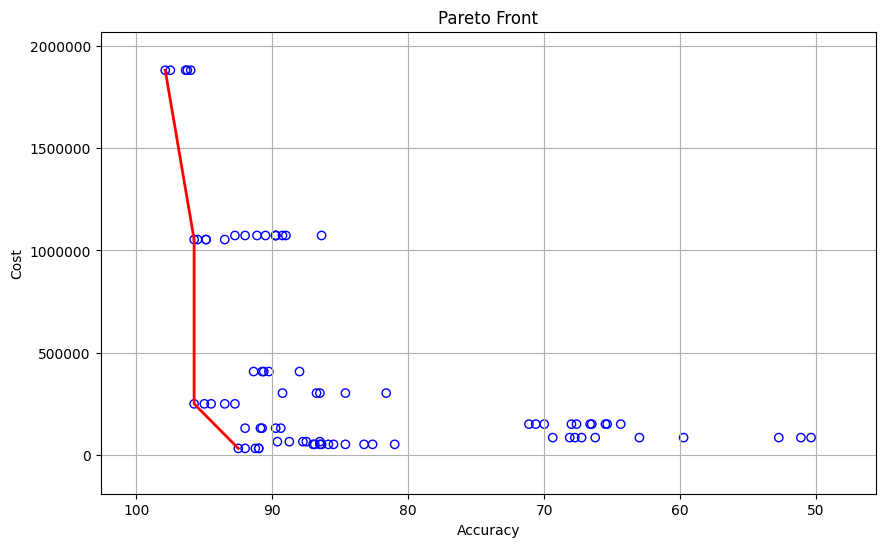

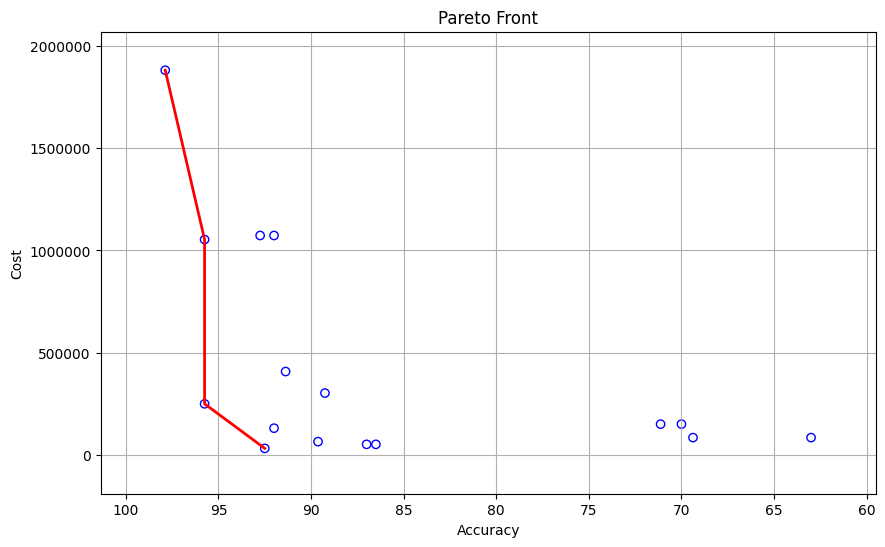

In [7]:
from matplotlib import pyplot as plt
import numpy as np

from src.nas.plot import plot_pareto_front


with_bias_acc = []
cost = []
for _, row in df.iterrows():
    accuracies = row["accuracies"] if isinstance(row["accuracies"], list) else row["accuracies"].strip("[]").split(", ")
    for accuracy in accuracies:
        with_bias_acc.append(float(accuracy))
        cost.append(row["cost"])

fig = plot_pareto_front(with_bias_acc, cost)
fig = plot_pareto_front(df["best"], df["cost"])



In [8]:
import plotly.express as px

fig = px.scatter(
    pd.read_csv("tmp2.csv"),
    x="best",
    y="cost",
    color="conv_compression",
    title="Best Accuracy vs Cost",
    hover_data=["conv_activation", "conv_compression"],
    labels={
        "cost": "Model Cost",
        "best": "Best Accuracy (%)",
        "conv_activation": "Conv Activation",
        "conv_compression": "Conv Compression"
    }
)
fig.update_xaxes(autorange="reversed")
fig.show()

In [9]:
import plotly.express as px

fig = px.scatter(
    pd.read_csv("tmp.csv"),
    x="best",
    y="cost",
    color="conv_compression",
    title="Best Accuracy vs Cost",
    hover_data=["conv_activation", "conv_compression"],
    labels={
        "cost": "Model Cost",
        "best": "Best Accuracy (%)",
        "conv_activation": "Conv Activation",
        "conv_compression": "Conv Compression"
    }
)
fig.update_xaxes(autorange="reversed")
fig.show()

In [19]:
from src.nas.plot import get_pareto_points


no_bias = pd.read_csv("tmp2.csv")
with_bias = pd.read_csv("tmp.csv")
no_bias["bias"] = "No Bias"
with_bias["bias"] = "With Bias"

df = pd.concat([no_bias, with_bias], ignore_index=True)
fig = px.scatter(
    df,
    x="best",
    y="cost",
    color="bias",
    symbol="conv_activation",
    title="Best Accuracy vs Cost with/without Bias",
    hover_data=["conv_activation", "conv_compression"],
    labels={
        "cost": "Model Cost",
        "best": "Best Accuracy (%)",
        "conv_activation": "Conv Activation",
        "conv_compression": "Conv Compression",
    },
)

pareto_points = get_pareto_points(df["best"], df["cost"])
pareto_lines = []
for i in range(len(pareto_points) - 1):
    first = pareto_points[i]
    second = pareto_points[i + 1]
    pareto_lines.append((first, second))

for first, second in pareto_lines:

    fig.add_shape(
        type="line",
        x0=first[0],
        x1=second[0],
        y0=first[1],
        y1=second[1],
        line=dict(color="Red", width=2),
    )

fig.update_xaxes(autorange="reversed")
fig.show()

In [11]:
list(no_bias["mean"]), list(with_bias["mean"])

([92.3,
  87.8,
  91.15,
  95.1,
  86.75,
  67.025,
  70.0,
  89.5,
  82.5,
  58.075,
  68.65,
  91.375,
  94.275,
  86.875,
  90.55,
  96.575],
 [91.55,
  88.025,
  90.55,
  94.9,
  86.15,
  67.75,
  68.575,
  89.275,
  83.775,
  55.4,
  66.575,
  90.775,
  94.3,
  85.75,
  90.2,
  96.8])

In [12]:
no_bias_acc = []
for _, row in no_bias.iterrows():
    accuracies = row["accuracies"].strip("[]").split(", ")
    for accuracy in accuracies:
        no_bias_acc.append(accuracy)
",".join(no_bias_acc)

'92.625,92.375,94.125,91.375,91.0,86.875,87.375,89.375,87.5,87.875,91.125,91.25,92.5,89.75,91.125,95.375,95.25,96.5,95.0,93.375,85.25,86.75,87.75,86.625,87.375,67.625,66.625,73.0,60.5,67.375,70.5,70.375,70.875,69.125,69.125,90.25,90.125,90.875,85.5,90.75,82.625,82.0,81.875,81.75,84.25,62.5,52.875,59.625,54.375,61.0,71.25,69.625,68.75,65.5,68.125,91.625,90.5,92.75,90.0,92.0,94.5,94.75,96.125,92.875,93.125,85.5,87.5,86.875,85.875,88.625,90.5,91.375,91.875,90.75,88.25,97.125,96.0,97.375,96.375,96.0'

In [13]:
with_bias_acc = []
for _, row in with_bias.iterrows():
    accuracies = row["accuracies"].strip("[]").split(", ")
    for accuracy in accuracies:
        with_bias_acc.append(accuracy)
",".join(with_bias_acc)

'91.0,92.5,91.0,91.25,92.0,88.75,87.5,89.625,86.5,87.75,90.75,90.875,92.0,89.375,89.75,95.5,93.5,94.875,95.75,94.875,86.375,85.875,87.0,84.625,86.875,68.125,67.75,67.25,66.25,69.375,66.625,70.625,68.0,71.125,66.5,89.75,89.25,92.0,86.375,89.0,82.625,85.5,86.5,81.0,83.25,51.125,52.75,50.375,63.0,59.75,65.375,67.625,70.0,65.5,64.375,90.5,89.75,92.75,89.75,91.125,95.0,92.75,95.75,93.5,94.5,84.625,86.5,89.25,81.625,86.75,90.75,90.25,91.375,88.0,90.625,97.5,96.25,97.875,96.0,96.375'